In [1]:
import numpy as np # 수치연산 관련 패키지
import pandas as pd # DataFrame을 다루는 데이터 전처리 패키지
from scipy import stats # statistics tools
import statsmodels.api as sm # linear models
import matplotlib.pyplot as plt # 기본 시각화 패키지
import seaborn as sns # 고급(?) 시각화 패키지 - R의 ggplot 같은겁니다.

# Seaborn 시각화 환경 세팅
sns.set_theme(style='white',
              rc = {'axes.unicode_minus': False,
                    'axes.spines.top':False,
                    'axes.spines.right':False,
                    'font.family':'NanumGothic', #폰트이름 (ex. AppleGothic)
                    'font.weight':'normal'})
sns.despine(left=True, bottom=True)
sns.set_palette('tab10')

<Figure size 432x288 with 0 Axes>

In [2]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

In [3]:
hoteldf = pd.read_csv('./data/L10_cluster_analysis.csv')
hoteldf = hoteldf.rename({'Vacation.':'VacationMoney'}, axis=1)
hoteldf.head(5)

,Visit,Income,TravelAttitude,VacationImp,HHSize,HHHeadAge,VacationMoney
0,1,50.2,5,8,3,43,2
1,1,70.3,6,7,4,61,3
2,1,62.9,7,5,6,52,3
3,1,48.5,7,5,5,36,1
4,1,52.7,6,6,4,55,3


In [4]:
from sklearn.preprocessing import minmax_scale #0-1 표준화
schoteldf = pd.DataFrame(minmax_scale(hoteldf), columns=hoteldf.columns).drop('Visit', axis=1)
schoteldf.head(5)

,Income,TravelAttitude,VacationImp,HHSize,HHHeadAge,VacationMoney
0,0.421911,0.571429,1.000000,0.2,0.21875,0.5
1,0.890443,0.714286,0.857143,0.4,0.78125,1.0
2,0.717949,0.857143,0.571429,0.8,0.50000,1.0
3,0.382284,0.857143,0.571429,0.6,0.00000,0.0
4,0.480186,0.714286,0.714286,0.4,0.59375,1.0


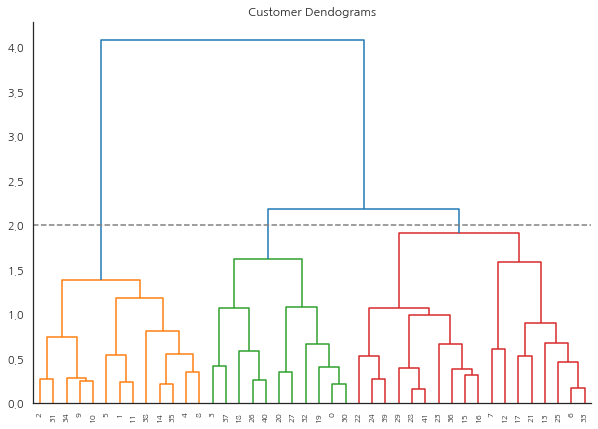

In [5]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(schoteldf, method='ward'), 
                      color_threshold=2)
plt.axhline(y=2, linestyle='--', color='gray')
plt.show()

In [6]:
clusterdf = pd.DataFrame(zip(dend['leaves'], dend['leaves_color_list']), 
                         columns=['index', 'cluster'])
clusterdf = clusterdf.sort_values('index').reset_index(drop=True)
clusterdf.head(5)

,index,cluster
0,0,C2
1,1,C1
2,2,C1
3,3,C2
4,4,C1


In [7]:
hoteldf['hierarchy_cluster'] = clusterdf['cluster']
hoteldf.groupby('hierarchy_cluster').mean()

,Visit,Income,TravelAttitude,VacationImp,HHSize,HHHeadAge,VacationMoney
hierarchy_cluster,,,,,,,
C1,0.923077,64.115385,6.230769,6.000000,4.461538,54.230769,3.000000
C2,0.363636,48.254545,5.909091,5.272727,3.272727,42.545455,1.636364
C3,0.277778,42.744444,3.277778,3.777778,3.444444,54.388889,1.500000


In [8]:
from sklearn.cluster import KMeans
np.random.seed(0)
kmeans_cluster = KMeans(n_clusters=3)  
kmeans_cluster.fit_predict(schoteldf)

array([2, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2,
       1, 1, 1, 2, 2, 1, 1, 1, 2, 0, 0, 2, 0, 0, 1, 1, 2, 1, 2, 1],
      dtype=int32)

In [9]:
hoteldf['kmeans_cluster'] = kmeans_cluster.labels_
hoteldf.groupby('kmeans_cluster').mean()

,Visit,Income,TravelAttitude,VacationImp,HHSize,HHHeadAge,VacationMoney
kmeans_cluster,,,,,,,
0,1.000000,64.592857,5.857143,6.285714,4.642857,55.214286,2.857143
1,0.071429,38.964286,4.142857,4.357143,3.428571,49.714286,1.000000
2,0.428571,48.850000,4.642857,3.928571,3.071429,48.785714,2.142857


In [10]:
print('Kaiser-Meyer-Olkin(KMO) Test :', calculate_kmo(schoteldf)[1]) # recommended to be above .6
print('Bartlett’s test p-value :', calculate_bartlett_sphericity(schoteldf)[1]) # should be rejected

Kaiser-Meyer-Olkin(KMO) Test : 0.6125588614082014
Bartlett’s test p-value : 3.395064989287618e-10


/home/hunnae/anaconda3/lib/python3.8/site-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


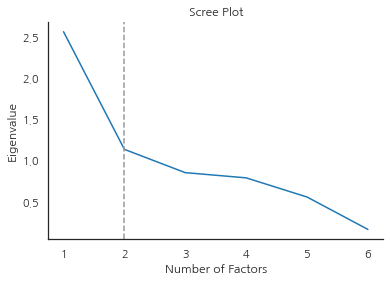

In [11]:
fa = FactorAnalyzer(n_factors=5, rotation=None)
fa.fit(schoteldf)
ev, v = fa.get_eigenvalues()

fig = sns.lineplot(x=range(1, len(ev)+1), y=ev)
fig.set(title='Scree Plot', xlabel='Number of Factors', ylabel='Eigenvalue')
plt.axvline(2, color=[.6,.6,.6], linestyle='--')
plt.show()

In [12]:
var_fa = FactorAnalyzer(n_factors=2, rotation='varimax')
var_fa.fit(schoteldf)

variancedf = pd.DataFrame(var_fa.get_factor_variance())
variancedf.columns = 'Factor #'+pd.Series(variancedf.columns).astype(str)
variancedf.index = ['SS Loadings', 'Proportion Var', 'Cumulative Var']

loadingsdf = pd.DataFrame(var_fa.loadings_)
loadingsdf.columns = 'Factor #'+pd.Series(loadingsdf.columns).astype(str)
loadingsdf.index = schoteldf.columns
loadingsdf

,Factor #0,Factor #1
Income,0.975619,0.058159
TravelAttitude,0.469747,-0.154481
VacationImp,0.369584,0.110119
HHSize,0.419734,0.028951
HHHeadAge,0.073490,0.996604
VacationMoney,0.816783,0.157601


In [13]:
# 지금 이 코드에서는 이중for문 사용해서 프로그래밍 안 익숙한 분들은 좀 헷갈릴 수 있습니다.
for factor_name in loadingsdf.columns :
    list_factorweight = []
    for variable, weight in loadingsdf[factor_name].to_dict().items() : # ex. (Afford, -0.66)
        list_factorweight.append(hoteldf[variable]*weight)
    hoteldf[factor_name] = np.mean(list_factorweight, axis=0)

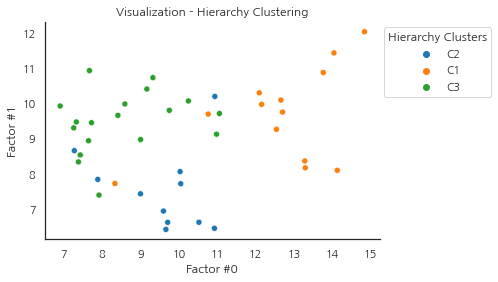

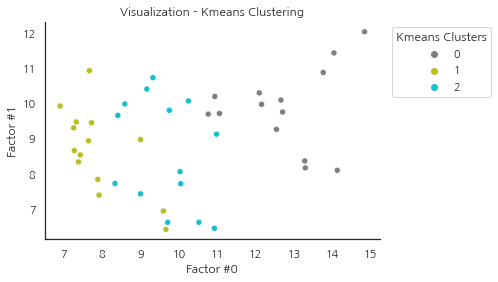

In [14]:
# Hierarchy Clustering
fig = sns.scatterplot(x='Factor #0', y='Factor #1', hue='hierarchy_cluster',
                      palette=sns.color_palette()[:3],
                      data=hoteldf)
fig.set(title='Visualization - Hierarchy Clustering')
fig.legend(title='Hierarchy Clusters', loc='upper right', bbox_to_anchor=(1.35,1))
plt.show()

# Kmeans Clustering
fig = sns.scatterplot(x='Factor #0', y='Factor #1', hue='kmeans_cluster',
                      palette=sns.color_palette()[7:10],
                      data=hoteldf)
fig.set(title='Visualization - Kmeans Clustering')
fig.legend(title='Kmeans Clusters', loc='upper right', bbox_to_anchor=(1.35,1))
plt.show()